# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env.brain_names

['TennisBrain']

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
from collections import deque
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import pandas as pd
import datetime 
import time

# Model

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            # if dim of state is 1, it cannot execute batch normalization
            state = torch.unsqueeze(state, 0)
        x = F.leaky_relu(self.fc1(state))
        x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.bn2(x)
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            # if dim of state is 1, it cannot execute batch normalization
            state = torch.unsqueeze(state, 0)
        xs = F.leaky_relu(self.fcs1(state))
        xs = self.bn(xs)
        if state.dim() == 1:
            action = torch.unsqueeze(action, 0)
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)


# Agent

In [9]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim


class MADDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, memory, device='cpu', params=None):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            memory (obj): Memory buffer to sample
            device (str): device string between cuda:0 and cpu
            params (dict): hyper-parameters
        """
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.step_t = 0
        self.update_every = params['update_every']

        # Set parameters
        self.gamma = params['gamma']
        self.tau = params['tau']
        self.seed = random.seed(params['seed'])

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, params['seed'],
                                 params['actor_units'][0], params['actor_units'][1]).to(device)
        self.actor_target = Actor(state_size, action_size, params['seed'],
                                  params['actor_units'][0], params['actor_units'][1]).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=params['lr_actor'])

        self.critic_local = Critic(state_size, action_size, params['seed'],
                                              params['critic_units'][0], params['critic_units'][1]).to(device)
        self.critic_target = Critic(state_size, action_size, params['seed'],
                                               params['critic_units'][0], params['critic_units'][1]).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),
                                                      lr=params['lr_critic'], weight_decay=params['weight_decay'])

        # Noise process
        self.noise = OUNoise(action_size, params['seed'], theta=params['noise_theta'], sigma=params['noise_sigma'])

        # Replay memory
        self.memory = memory


    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        self.step_t = (self.step_t + 1) % self.update_every

        # Learn, if enough samples are available in memory
        if self.step_t == 0 and len(self.memory) > self.memory.get_batch_size():
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)

        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    @staticmethod
    def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

# memory

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (str): cuda:0 for GPU or cpu
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        experiences = [e for e in experiences if e is not None]

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(self.device)

        return states, actions, rewards, next_states, dones

    def get_batch_size(self):
        return self.batch_size

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Main loop

In [17]:
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


params = {
    'buffer_size': int(1e6),        # replay buffer size
    'batch_size': 128,              # minibatch size
    'seed': 0,                      # Seed to generate random numbers
    'gamma': 0.99,                      # discount factor
    'tau': 0.15,                        # for soft update of target parameters
    'update_every': 1,                  # update parameters per this number
    'lr_actor': 5e-4,                   # learning rate of the Actor
    'lr_critic': 3e-3,                  # learning rate of the Critic
    'seed': 42,                         # Seed to generate random numbers
    'actor_units': [512, 256],          # Number of nodes in hidden layers of the Actor
    'critic_units': [512, 256],         # Number of nodes in hidden layers of the Critic
    'weight_decay': 0,                  # L2 weight decay
    'noise_theta': 0.15,                # Theta of Ornstein-Uhlenbeck process
    'noise_sigma': 0.01,                # Sigma of Ornstein-Uhlenbeck process
}


memory = ReplayBuffer(action_size, params['buffer_size'],
                      params['batch_size'], params['seed'], torch_device)


def train(n_episodes=150, max_t=1500, agents=None, filenames=None,
          benchmark_score=0.5, rolling_n_episodes=10):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode (should be over 1000)
        agents (obj): training agent instances
        filenames (list): string of filenames to store weights of actor and critic
        benchmark_score (int): the score of agent should be over this score
        rolling_n_episodes (int): the score is checked whenever number of tries reachs to this
    """
    start_time = time.time()
        
    all_scores = []                                   # list containing scores from each episode for all agents
    scores_window = deque(maxlen=rolling_n_episodes)  # last rolling_n_episodes scores
    avg_checked = False
    max_score = -1
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state (for each agent)
        scores = np.zeros(len(agents))                     # initialize the score (for each agent)

        for agent in agents:                               # Reset agent before starting new episode
            agent.reset()

        for t in range(max_t):
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]  # select actions
            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished

            for i, agent in enumerate(agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            
            states = next_states                           # roll over the state to next time step
            scores += rewards                              # update the score
            if np.any(dones):                              # exit loop if episode finished
                break

        cur_score = np.max(scores)                         # average score of all agents
        scores_window.append(cur_score)                    # save most recent score
        all_scores.append(cur_score)                       # save all scores
        avg_scores_window = np.mean(scores_window)         # get average score of current window

        if cur_score > max_score:
            max_score = cur_score
            if filenames:
                for i, agent in enumerate(agents):
                    torch.save(agent.actor_local.state_dict(), filenames[0] + str(i) + '.pth')
                torch.save(agent.critic_local.state_dict(), filenames[1] + '.pth')

        print('\ri_episode {}\tavg_scores_window: {:.5f}\tcurrent_score: {:.5f}'.format(i_episode, avg_scores_window, cur_score), end="")
        
        if i_episode % rolling_n_episodes == 0:
            print('\ri_episode {}\tavg_scores_window: {:.5f}\tcurrent_score: {:.5f}'.format(i_episode, avg_scores_window, cur_score))
        
        if not avg_checked and avg_scores_window >= benchmark_score:
            print('\nEnvironment solved in {:d} episodes!\tavg_scores_window: {:.5f}'.format(
                  i_episode - rolling_n_episodes, avg_scores_window))
            avg_checked = True

    return all_scores

In [18]:
maddpg_agents = [MADDPGAgent(state_size, action_size, memory, torch_device, params)
                 for _ in range(num_agents)]

In [19]:
rundates= datetime.datetime.now().strftime('%Y%m%d_%H%M')
rolling_n_episodes = 10     # Score is checked whenever number of tries reachs to this.
benchmark_score = 0.5      # min score of agent 
maddpg_scores = train(200, 1500, maddpg_agents, ['actor_model', 'critic_model'],
                      benchmark_score, rolling_n_episodes)

i_episode 10	avg_scores_window: 0.00000	current_score: 0.00000
i_episode 20	avg_scores_window: 0.01900	current_score: 0.00000
i_episode 30	avg_scores_window: 0.00000	current_score: 0.00000
i_episode 40	avg_scores_window: 0.01000	current_score: 0.00000
i_episode 50	avg_scores_window: 0.02000	current_score: 0.00000
i_episode 60	avg_scores_window: 0.02800	current_score: 0.00000
i_episode 70	avg_scores_window: 0.03900	current_score: 0.00000
i_episode 80	avg_scores_window: 0.06800	current_score: 0.10000
i_episode 90	avg_scores_window: 0.06800	current_score: 0.00000
i_episode 100	avg_scores_window: 0.07800	current_score: 0.10000
i_episode 110	avg_scores_window: 0.08000	current_score: 0.10000
i_episode 120	avg_scores_window: 0.12000	current_score: 0.10000
i_episode 130	avg_scores_window: 0.09000	current_score: 0.20000
i_episode 140	avg_scores_window: 0.11800	current_score: 0.00000
i_episode 150	avg_scores_window: 0.31900	current_score: 1.00000
i_episode 156	avg_scores_window: 0.55900	current_

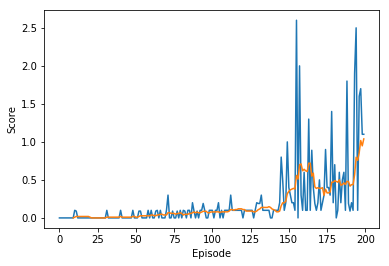

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(maddpg_scores)), maddpg_scores)
maddpg_avg = pd.Series(maddpg_scores).rolling(rolling_n_episodes).mean()
plt.plot(np.arange(len(maddpg_avg)), maddpg_avg)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()
plt.savefig("results.png")